In [1]:
!pwd
from google.colab import drive
drive.mount('/content/drive')

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# unzip
import zipfile, os, shutil

dataset = '/content/drive/MyDrive/datasets/cifake.zip'
data_path = '/content/drive/MyDrive/cifake_local'
data_file = os.path.join(data_path, 'cifake.zip')

if not os.path.exists(data_path):
  os.makedirs(data_path)

# copy zip file
shutil.copy(dataset, data_file)
  
with zipfile.ZipFile(data_file, 'r') as file: 
  file.extractall(data_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [3]:

dataset_dir = '/content/drive/MyDrive/cifake_local/cifake' # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory
print("Loading dataset from: " + dataset_dir)

Loading dataset from: /content/drive/MyDrive/cifake_local/cifake


In [ ]:
# Import all of the data using dataset from directory
# If there isn't enough RAM available, consider using Tensorflow Datasets 

import tensorflow as tf

img_height = 32 # The dataset is all 32px but this is here just to make sure
img_width = 32
batch_size = 32

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir + "/train",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=None)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/valid",
  seed=123,
  image_size=(img_height, img_width),
    batch_size=None)

# Load the validation data
test_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/test",
  seed=123,
  image_size=(img_height, img_width),
    batch_size=None)

# Quick sanity check to make sure it's all loaded properly
print("Training Classes:")
class_names = train_ds.class_names
print(class_names)


print("Training Classes:")
class_names = val_ds.class_names
print(class_names)


print("Testing Classes:")
class_names = test_ds.class_names
print(class_names)

In [ ]:
for img_batch, label_batch in train_ds.take(1) : 
    print(img_batch.shape)
    print(label_batch.numpy()) 

(32, 32, 3)
1


In [ ]:
def normalize_and_resize(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, (224, 224))
 
    return image, label

In [ ]:
train_batches = train_ds.map(normalize_and_resize).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = val_ds.map(normalize_and_resize).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_ds.map(normalize_and_resize).batch(1)
print(train_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
def build_model():
    base_model = tf.keras.applications.VGG16(input_shape= (224,224, 3),
                                             weights='imagenet',
                                             include_top=False)
    
    # add a GAP layer
    output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
 
    # output has two neurons for the 2 classes(dogs and cats)
    output = tf.keras.layers.Dense(2, activation='softmax')(output)
 
    # set the inputs and outputs of the model
    model = tf.keras.Model(base_model.input, output)
 
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    model.summary()
 
    return model
    
model = build_model()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
EPOCHS = 10
model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/10
175/175 [==============================] - 1128s 6s/step - loss: 0.4309 - acc: 0.8806 - val_loss: 0.6528 - val_acc: 0.7141
Epoch 2/10
175/175 [==============================] - 11s 57ms/step - loss: 0.2324 - acc: 0.9134 - val_loss: 0.8751 - val_acc: 0.6218
Epoch 3/10
175/175 [==============================] - 11s 55ms/step - loss: 0.1965 - acc: 0.9266 - val_loss: 0.6795 - val_acc: 0.7453
Epoch 4/10
175/175 [==============================] - 11s 60ms/step - loss: 0.1625 - acc: 0.9393 - val_loss: 0.3644 - val_acc: 0.8499
Epoch 5/10
175/175 [==============================] - 12s 63ms/step - loss: 0.1402 - acc: 0.9552 - val_loss: 0.5217 - val_acc: 0.8183
Epoch 6/10
175/175 [==============================] - 11s 59ms/step - loss: 0.1219 - acc: 0.9601 - val_loss: 0.5663 - val_acc: 0.8251
Epoch 7/10
175/175 [==============================] - 11s 56ms/step - loss: 0.0915 - acc: 0.9674 - val_loss: 0.8764 - val_acc: 0.7671
Epoch 8/10
175/175 [==============================] - 10s 54ms

In [ ]:
cam_model = tf.keras.Model(model.input, outputs=(model.layers[-3].output, model.layers[-1].output))
cam_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(512, 2)

In [ ]:
def show_cam(image_value, features, results, label):
    '''
    Displays the class activation map of an image
 
    Args:
        image_value (tensor) -- preprocessed input image with size 224 x 224
        features (array) -- features of the image, shape (1, 7, 7, 512)
        results (array) -- output of the sigmoid layer
    '''
    features_for_img = features[0]
    prediction = results[0]
 
    class_activation_weigths = gap_weights[:,label]
    class_activation_features = sp.ndimage.zoom(features_for_img, (224/7, 224/7, 1), order=2)
    cam_output = np.dot(class_activation_features, class_activation_weigths)
    cam_output = tf.reshape(cam_output, (224,224))
 
    # visualize the results
    print(f'sigmoid output: {results}')
    print(f"prediction: {'real' if tf.argmax(results[0]) else 'fake'}")
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()

In [ ]:
# preprocess the test images
augmented_test_data = val_ds.map(normalize_and_resize)
test_batches = augmented_test_data.batch(1)

ground truth: real
1/1 [==============================] - 1s 777ms/step
sigmoid output: [[9.148154e-08 9.999999e-01]]
prediction: fake


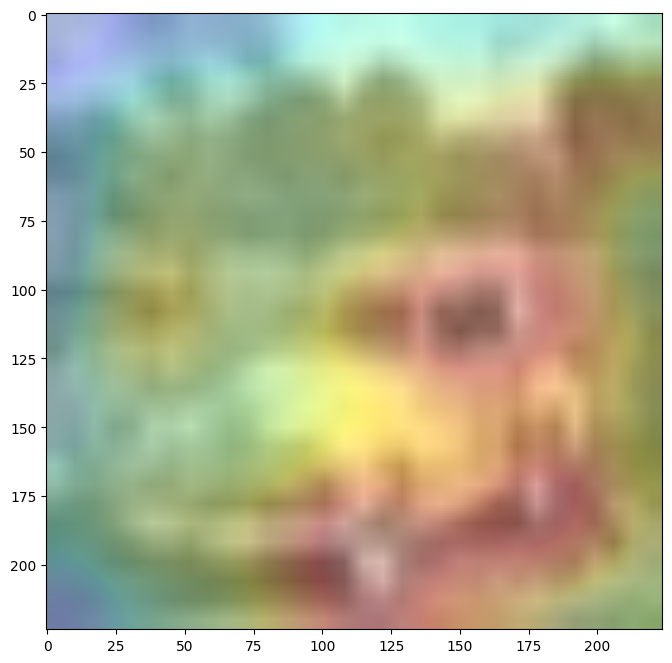

ground truth: real
1/1 [==============================] - 0s 33ms/step
sigmoid output: [[1.1474237e-05 9.9998856e-01]]
prediction: fake


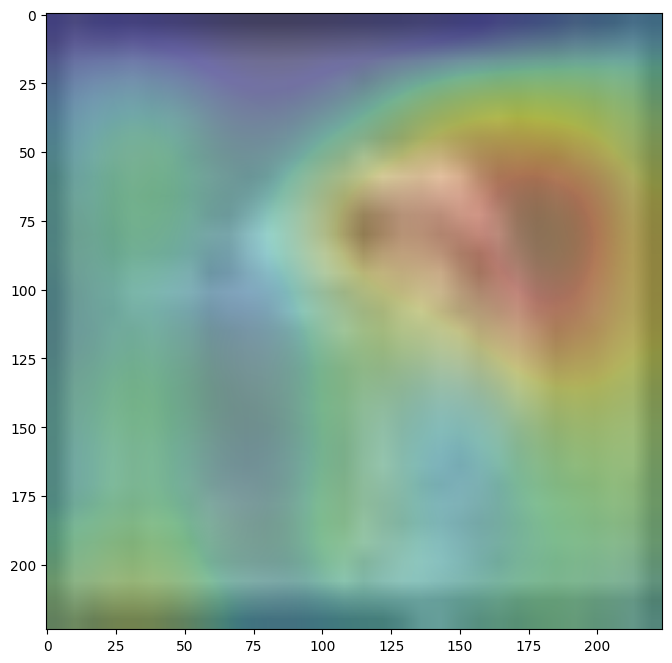

ground truth: real
1/1 [==============================] - 0s 25ms/step
sigmoid output: [[8.855051e-08 9.999999e-01]]
prediction: fake


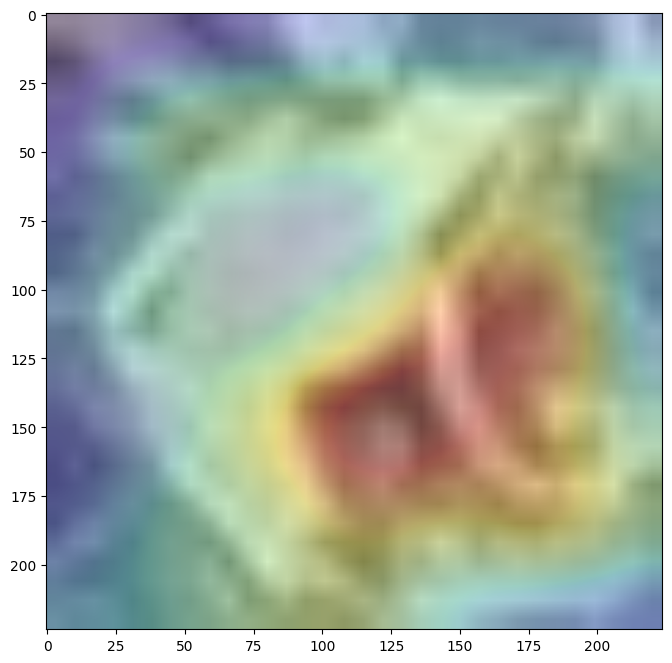

ground truth: fake
1/1 [==============================] - 0s 26ms/step
sigmoid output: [[4.6462092e-06 9.9999535e-01]]
prediction: fake


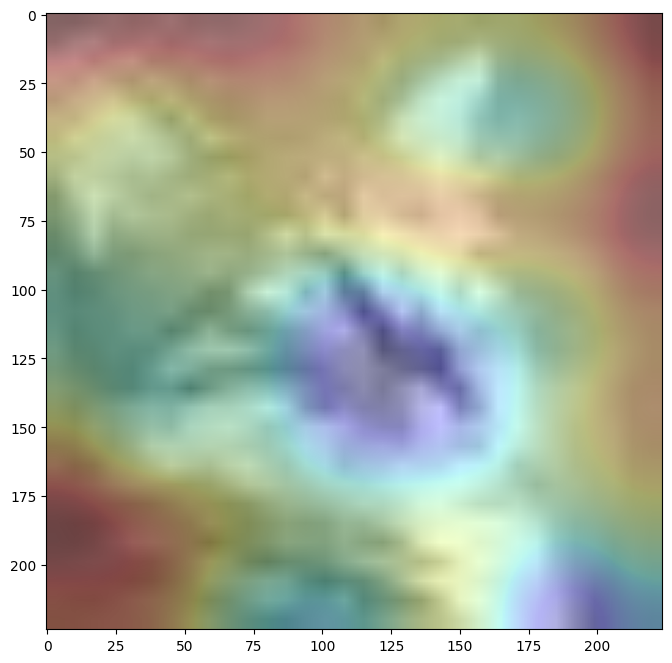

ground truth: fake
1/1 [==============================] - 0s 33ms/step
sigmoid output: [[2.0739178e-06 9.9999797e-01]]
prediction: fake


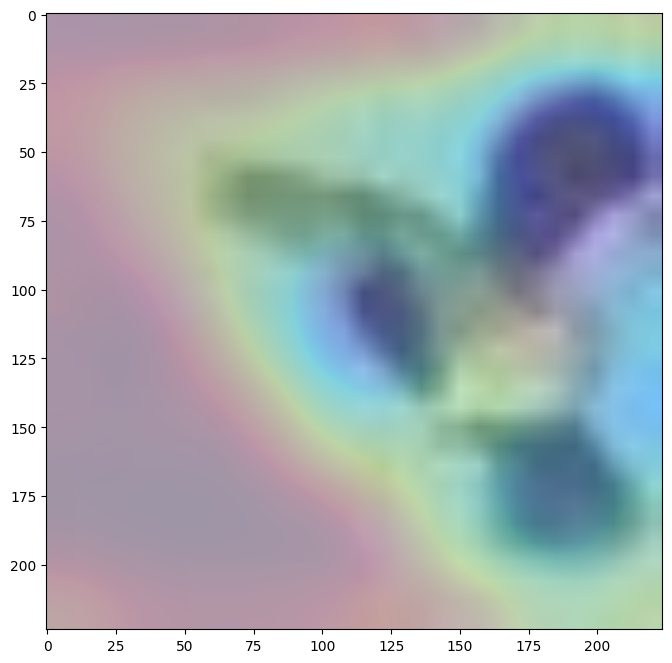

In [ ]:
for img, lbl in test_batches.take(5):
    print(f"ground truth: {'real' if lbl else 'fake'}")
    features,results = cam_model.predict(img)
    show_cam(img, features, results, lbl)
